In [19]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rc
from numpy import linalg as LA
import csv
import sqlite3
from sqlite3 import Error
from pandas import DataFrame
from statistics import mean 
from scipy.stats import sem
from scipy.stats import t
import re
from matplotlib.pyplot import text
import statistics
import math
from pathlib import Path

In [20]:
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None

In [21]:
def selectMeanDelay(conn):
    df=pd.read_sql_query("SELECT avg(v.scalarValue)*1000 delay FROM scalar v where v.scalarName='delay:mean' and  v.scalarValue NOT NULL  and v.moduleName like '%.applLayer[0]'",conn)
    return df


def selectMeanThroughput(conn):
    df=pd.read_sql_query("SELECT avg(v.scalarValue)/1000000 th FROM scalar v where v.scalarName='throughput:mean' and  v.scalarValue NOT NULL",conn)
    return df


In [22]:
def treatData(path):
    conex=create_connection(path)
    ## Delay
    delay=selectMeanDelay(conex)
    ## Th
    th= selectMeanThroughput(conex)
    return (delay.squeeze(),th.squeeze())

### DATA treatment

In [23]:
def Extractrepeat(commonPath,fileName,repeat,start,end,step):
    n=len(list(range(start,end,step)))
    k=0

    delay_r=[None]*repeat
    th_r=[None]*repeat
    
    delay_m=[None]*n
    th_m=[None]*n
    
    delay_err=[None]*n
    th_err=[None]*n
    
    for i in range(start,end,step):
        #print(i)
        for j in range(0,repeat):
            path=commonPath+fileName+'-'+str(i)+'-'+str(j)+'.sca'
            delay_r[j],th_r[j]=treatData(path) 
        ### delay
        delay_m[k]=mean(delay_r)
        delay_err[k]=statistics.stdev(delay_r)
        ### throughput
        th_m[k]=mean(th_r)
        th_err[k]=statistics.stdev(th_r)
        k=k+1
    return (delay_m,delay_err,th_m, th_err)

In [24]:
### General settings 
repeat=2
start=10
end=101
step=10
commonPath=str(Path.home())+'/Ali_Code/HeteroSIM/HeteroSIM/simulations/examples/unicast/'

In [25]:
loadTimePercent=list(range(start,end,step))
### Dummy-delay-based selection
delayRand20,delayRand20_err,thRand20,thRand20_err=Extractrepeat(commonPath+'naiveDelayBasedDecision/','naiveDelayBasedDecision',repeat,start,end,step)
### DICART 
delayVRU20,delayVRU20_err,thVRU20,thVRU20_err=Extractrepeat(commonPath+'delayWeighted/','delayWeighted',repeat,start,end,step)

### Graph delay for delay weighted use case

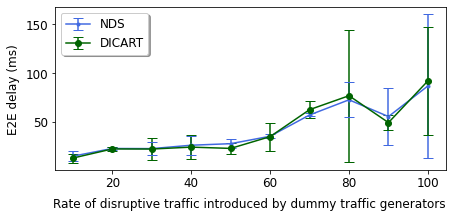

In [26]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(7,3))
fig.text(0.51, -0.05, "Rate of disruptive traffic introduced by dummy traffic generators", ha='center')
fig.text(0.03, 0.5, "E2E delay (ms)", va='center', rotation='vertical')
plt.subplot(111)
plt.errorbar(loadTimePercent,delayRand20,yerr=delayRand20_err,label="NDS",marker=".",  color="royalblue",capsize = 5)
plt.errorbar(loadTimePercent,delayVRU20,yerr=delayVRU20_err,label="DICART",marker="o",color="darkgreen",capsize = 5)
#plt.title("Low density")
#plt.subplot(122)
#plt.errorbar(loadTimePercent,delayRand80,yerr=delayRand80_err,label="NDS",marker=".",  color="royalblue",capsize = 5)
#plt.errorbar(loadTimePercent,delayVRU80,yerr=delayVRU80_err,label="DICART-VRU",marker="o",  color="darkgreen",capsize = 5)
plt.legend( loc = 'best',fancybox=True, shadow=True)
#plt.title("High density")
plt.subplots_adjust(hspace=0.4,wspace=0.2)
plt.savefig("Delay_delayWeighted.pdf")

### Graph Th for delay weighted use case

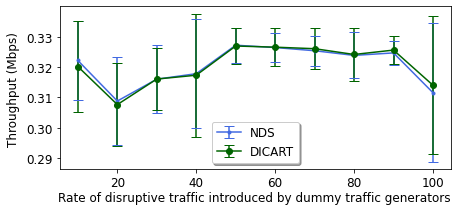

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(7,3))
fig.text(0.51, -0.02, "Rate of disruptive traffic introduced by dummy traffic generators", ha='center')
fig.text(0.02, 0.5, "Throughput (Mbps)", va='center', rotation='vertical')
plt.subplot(111)
plt.errorbar(loadTimePercent,thRand20,yerr=thRand20_err,marker=".",label="NDS",  color="royalblue",capsize = 5)
plt.errorbar(loadTimePercent,thVRU20,yerr=thVRU20_err,marker="o",label="DICART", color="darkgreen",capsize = 5)
plt.legend( loc = 'best',fancybox=True, shadow=True) 
#plt.title("Low density")
#plt.subplot(122)
#plt.errorbar(loadTimePercent,thRand80,yerr=thRand80_err,marker=".",  color="royalblue",capsize = 5)
#plt.errorbar(loadTimePercent,thVRU80,yerr=thVRU80_err,marker="o",  color="darkgreen",capsize = 5)
#plt.title("High density")
plt.subplots_adjust(hspace=0.4,wspace=0.2)
plt.savefig("Th_delayWeighted.pdf")